In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Autoregressive (ARX) Model  - Combining Multivariate Regression analysis.

* The purpose of this project was to explore cryptocurrency timeseries for forecasting future returns.
* A boilerplate pipeline was created for repetitive code, and to enhance reproducibility.
* Libraries used: Polars for efficient dataframe analysis / Seaborne&Matplotlib for visualization / Pytorch for model development.


In [109]:
# Import the modules needed for analysis.

from importlib import reload
import src.features as features
from features import get_digital_data
import src.visualization as visualization
import src.model as model
from src.model import set_seeds, time_split, train_test_split, train_model, evaluate_model, get_trade_results, get_strategy_metrics

### Fetching data from the Binance API

* Initial analysis was done on BTCUSDT, however the model found stronger performance on XRPUSDT.
* Multiple time horizons were tested, settling on the 8H bar to better deal with transaction costs.


In [110]:
df = features.get_digital_data("XRPUSDT","8h","2020-11-11")
df.head()

date,open,high,low,close,volume
datetime[ms],f64,f64,f64,f64,f64
2020-11-11 00:00:00,0.25379,0.25887,0.25209,0.25602,5.0436e7
2020-11-11 08:00:00,0.25602,0.26,0.25421,0.25752,5.8841e7
2020-11-11 16:00:00,0.25751,0.25947,0.25477,0.25581,4.6144e7
2020-11-12 00:00:00,0.25581,0.25782,0.253,0.25695,3.8538e7
2020-11-12 08:00:00,0.25695,0.25818,0.2534,0.25447,5.6230e7


### Transforming Close and Volume columns into logged space

In [45]:
df = features.create_time_series_transform(df,"close","volume",1)
df.head()

date,open,high,low,close,volume,close_log_return,log_volume
datetime[ms],f64,f64,f64,f64,f64,f64,f64
2020-11-11 00:00:00,0.25379,0.25887,0.25209,0.25602,5.0436e7,null,null
2020-11-11 08:00:00,0.25602,0.26,0.25421,0.25752,5.8841e7,0.005842,0.154127
2020-11-11 16:00:00,0.25751,0.25947,0.25477,0.25581,4.6144e7,-0.006662,-0.243069
2020-11-12 00:00:00,0.25581,0.25782,0.253,0.25695,3.8538e7,0.004447,-0.180118
2020-11-12 08:00:00,0.25695,0.25818,0.2534,0.25447,5.6230e7,-0.009699,0.377798


# Creating lagged features of the time series
* Using the lag_feature method, we create 4 lagged periods of the close log return and volume.
* This feature is adaptable to the users preference.

In [46]:
df = features.create_lag_feature(df,["close_log_return","log_volume"],4,1)
df.head()

date,open,high,low,close,volume,close_log_return,log_volume,close_log_return_lag1,close_log_return_lag2,close_log_return_lag3,close_log_return_lag4,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-11-12 16:00:00,0.25443,0.25554,0.2525,0.2549,4.5008e7,0.001688,-0.222619,-0.009699,0.004447,-0.006662,0.005842,0.377798,-0.180118,-0.243069,0.154127
2020-11-13 00:00:00,0.2549,0.25697,0.25384,0.25503,3.8617e7,0.00051,-0.153132,0.001688,-0.009699,0.004447,-0.006662,-0.222619,0.377798,-0.180118,-0.243069
2020-11-13 08:00:00,0.25498,0.2613,0.2535,0.25962,7.6404e7,0.017838,0.682328,0.00051,0.001688,-0.009699,0.004447,-0.153132,-0.222619,0.377798,-0.180118
2020-11-13 16:00:00,0.25955,0.2659,0.254,0.2659,7.8000e7,0.023901,0.020685,0.017838,0.00051,0.001688,-0.009699,0.682328,-0.153132,-0.222619,0.377798
2020-11-14 00:00:00,0.26587,0.2777,0.264,0.27011,1.50643936e8,0.015709,0.658206,0.023901,0.017838,0.00051,0.001688,0.020685,0.682328,-0.153132,-0.222619


### Plotting feature distribution
* With our features added to the dataframe, we visualize the pair plots of the features and target to each other.
* This gives us a visual representation of the relationship which will determine how we analyze the time series.

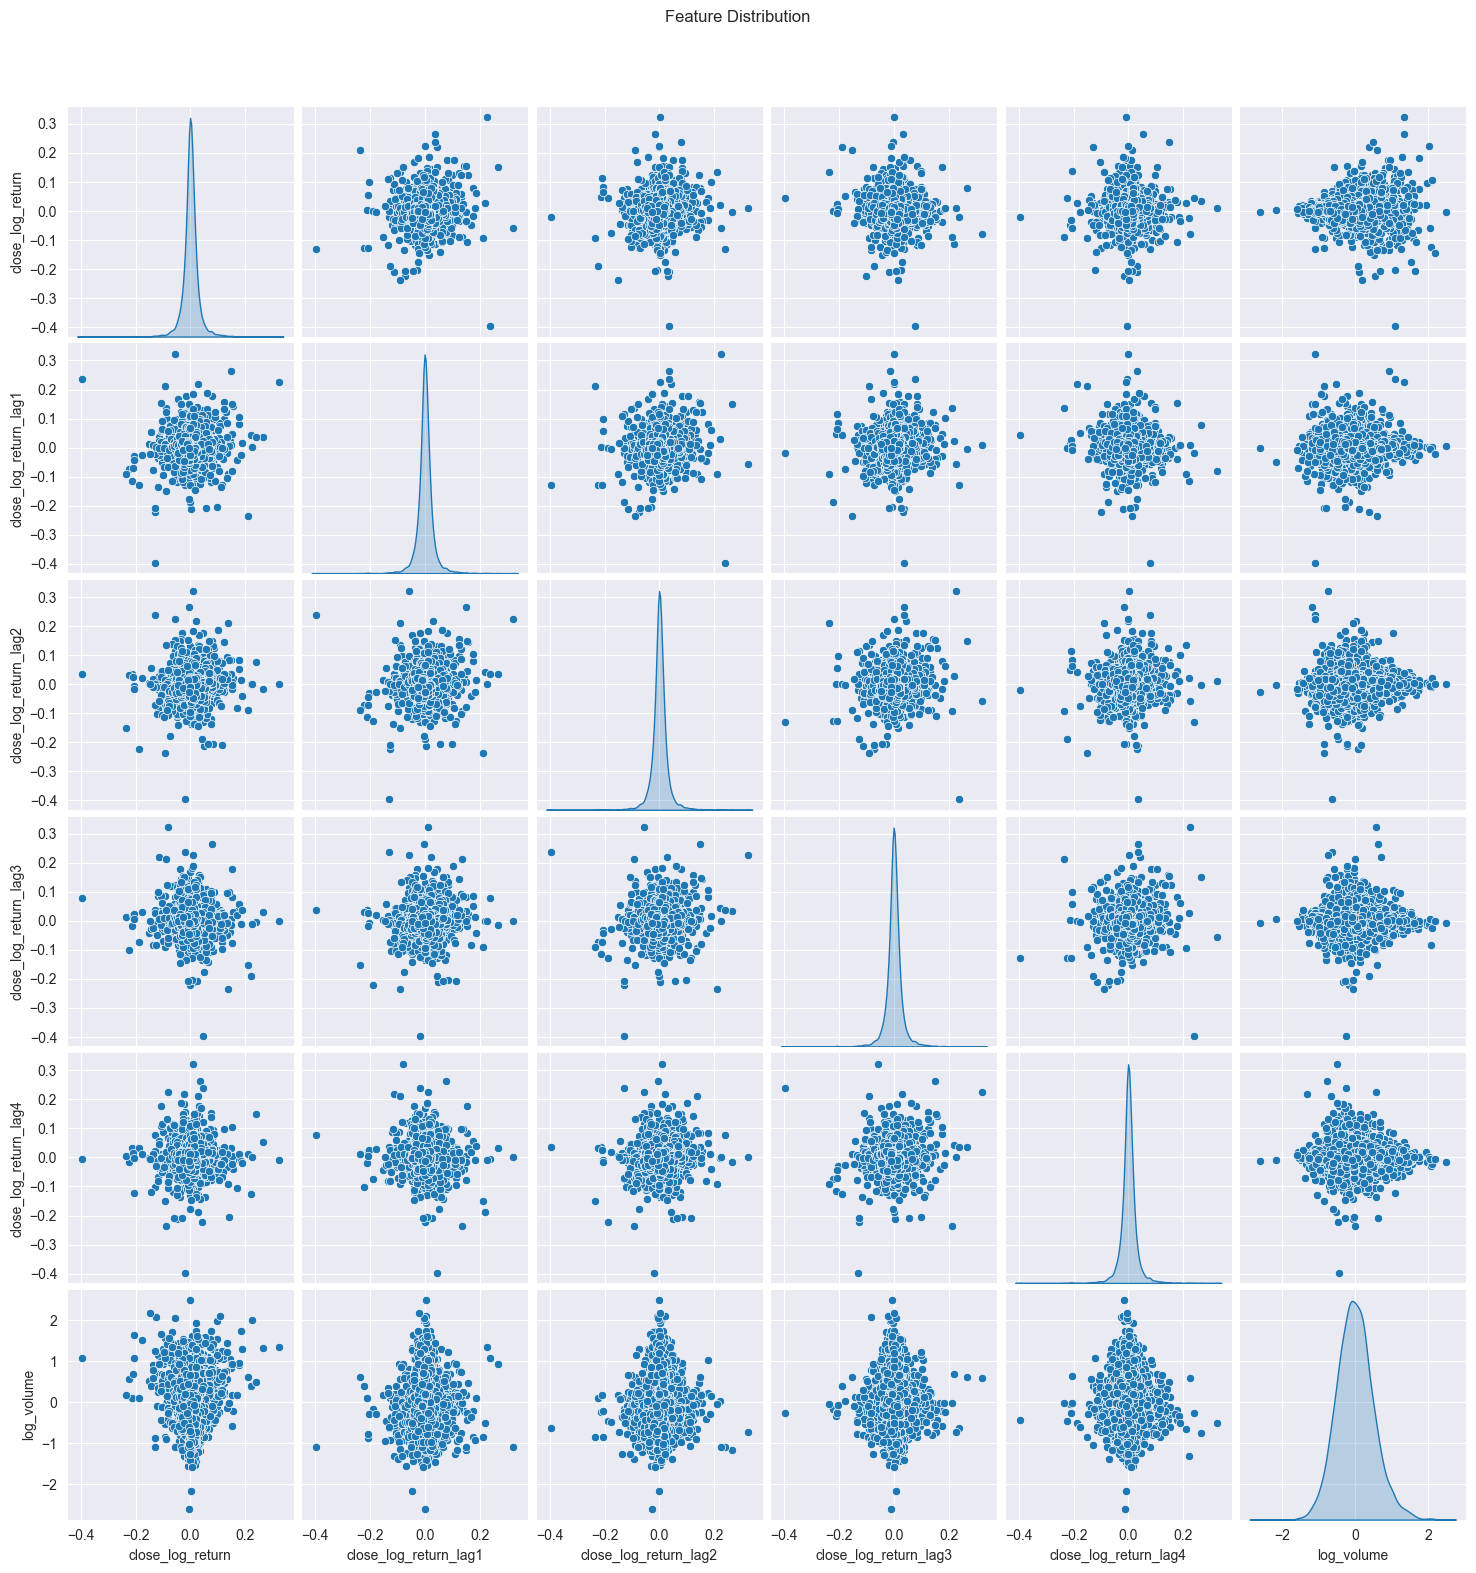

In [47]:
# plot feature distribution
visualization.plot_feature_distribution(df,["close_log_return","close_log_return_lag1","close_log_return_lag2","close_log_return_lag3","close_log_return_lag4","log_volume"])

### Feature Correlation vs Target
* Next we display the varying features and their absolute correlation to the close log return.

In [48]:
# plot feature correlation
visualization.display_feature_corr(df,"close_log_return")

Feature,Abs_correlation
str,f64
"""close_log_return""",1.0
"""close_log_return_lag3""",0.071508
"""close_log_return_lag2""",0.057307
"""close_log_return_lag1""",0.038006
"""log_volume_lag2""",0.030691
…,…
"""log_volume_lag4""",0.004232
"""low""",0.002956
"""log_volume_lag1""",0.002381


In [49]:
from model import set_seeds

### Model Development
* We utilized the Pytorch library to analyze two models:
* 1: Linear Regression - Best used for easier interoperability.
* 2: Neural Network - Given the non-linear relationship we observed above, initial expectation was for higher performance with the NN model.

* Results between the two models indicated that the NN model was too effected by the noise and thus settled for the Linear Regression to continue the analysis.

In [87]:
# Model Development
from src import model
# Set seed for reproducibility
set_seeds(seed=99)

# Features
from model import to_tensor
features = ["close_log_return_lag3","close_log_return_lag2","log_volume_lag2","log_volume_lag3"]
target = "close_log_return"

# Create Tensors and split dataframe after setting seeds
X_train, X_test, y_train, y_test = train_test_split(df,features,target,train_size=0.75)

In [88]:
from model import train_model

### Various iterations of the learning rate (lr) and epoch size were analyzed
* The lr of 0.002 and epoch of 2500 created an adequate horizon before the model got too noisy on the loss rate.

In [89]:
# Trained Model with a focus on the linear model in Pytorch, due to easier interoperability.
input_size = X_train.shape[1]
lr = 0.002
# Should the user wish to experiment, the argument of "linear" can be changed to "nn" for a neural network.

trained_model = train_model(X_train,y_train,input_size,"linear",lr=lr,epochs=2500,print_freq=500)


Model: Linear Regression
Starting training for 2500 epochs...
Epoch: 0000 | Loss: 0.263177
Epoch: 0500 | Loss: 0.018842
Epoch: 1000 | Loss: 0.018842
Epoch: 1500 | Loss: 0.018842
Epoch: 2000 | Loss: 0.018842

Training Complete.
------------------------------
Model Bias (Drift): -0.000110
Model Weights (Feature Importance):
  Feature 0: -0.067370
  Feature 1: 0.013525
  Feature 2: 0.001949
  Feature 3: -0.000236
------------------------------


### Evaluating Model Performance
* The model is picking up a mean reversion behaviour.
* Due to the time horizon being 8H, and the strongest feature the log_return_lag3, the results are interesting as they highlight a 24H reversal cycle.

In [90]:
# Evaluate model performance
from model import get_trade_results
y_hat = evaluate_model(trained_model, X_test)
results_df = get_trade_results(y_hat, y_test)
results_df

y_hat,y,is_won,signal,trade_log_return_gross,turnover,tx_cost_log,trade_log_return_net,equity_curve_gross,equity_curve_net,B_H_log_return,B_H_equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f64,f64,f32,f64,f32,f32,f64
-0.000823,-0.028576,true,-1.0,0.028576,0.0,-0.0,0.028576,0.028576,0.028576,-0.028576,-0.028576,0.0
0.001619,0.032643,true,1.0,0.032643,2.0,-0.001,0.031643,0.061219,0.060218,0.032643,0.004067,0.0
0.000166,-0.000353,false,1.0,-0.000353,0.0,-0.0,-0.000353,0.060866,0.059865,-0.000353,0.003714,-0.000353
0.000867,-0.000177,false,1.0,-0.000177,0.0,-0.0,-0.000177,0.060689,0.059689,-0.000177,0.003537,-0.00053
-0.004464,-0.000353,true,-1.0,0.000353,2.0,-0.001,-0.000647,0.061042,0.059042,-0.000353,0.003184,-0.001177
…,…,…,…,…,…,…,…,…,…,…,…,…
-0.001758,-0.011487,true,-1.0,0.011487,0.0,-0.0,0.011487,2.787864,1.967657,-0.011487,1.347869,-0.018454
0.000664,-0.009063,false,1.0,-0.009063,2.0,-0.001,-0.010063,2.778801,1.957594,-0.009063,1.338806,-0.028517
-0.001661,-0.026785,true,-1.0,0.026785,2.0,-0.001,0.025785,2.805586,1.983378,-0.026785,1.312021,-0.002732


In [111]:
import polars as pl
turnover_stats = results_df.select([
    pl.len().alias("total_rows"),
    pl.col("signal").diff().abs().gt(0).sum().alias("trade_count")
])
print(turnover_stats)

shape: (1, 2)
┌────────────┬─────────────┐
│ total_rows ┆ trade_count │
│ ---        ┆ ---         │
│ u32        ┆ u32         │
╞════════════╪═════════════╡
│ 1387       ┆ 824         │
└────────────┴─────────────┘


In [92]:
from src.model import get_strategy_metrics

### Performance Metrics
*  0.2 improvement in Sharpe was found when including the lagged volume feature.
* Strongest performance was found in feature close_log_return_lag3.
* Strategy returned a gross Sharpe of 2.4 before fees and 1.8 net of fees. Assuming a 0.5bps cost on a maker fee.

In [95]:
# Calculate performance metrics
import numpy as np
trading_periods = 365*3 # formula is looking at 365 trading days * by 3, 8 hour bars in a day.
ann_fac_sqrt = np.sqrt(trading_periods)
strategy_metrics_df = get_strategy_metrics(
    trade_results_df=results_df,
    annual_factor_sqrt=ann_fac_sqrt
)

print("--- PERFORMANCE SUMMARY NET OF FEES ---")
print(strategy_metrics_df)


--- PERFORMANCE SUMMARY NET OF FEES ---
shape: (1, 8)
┌────────────┬────────────┬────────────┬────────────┬──────────┬───────────┬───────────┬───────────┐
│ Total_Retu ┆ Annualized ┆ Max_Drawdo ┆ Drawdown_P ┆ Win_Rate ┆ Total_Tra ┆ Compound  ┆ Calmar_Ra │
│ rn         ┆ _Sharpe    ┆ wn         ┆ ct         ┆ ---      ┆ des       ┆ Return    ┆ tio       │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆ f64      ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆          ┆ i64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪════════════╪══════════╪═══════════╪═══════════╪═══════════╡
│ 1.983534   ┆ 1.784694   ┆ 0.611509   ┆ -0.457469  ┆ 0.552271 ┆ 1387      ┆ 7.268386  ┆ 3.24367   │
└────────────┴────────────┴────────────┴────────────┴──────────┴───────────┴───────────┴───────────┘


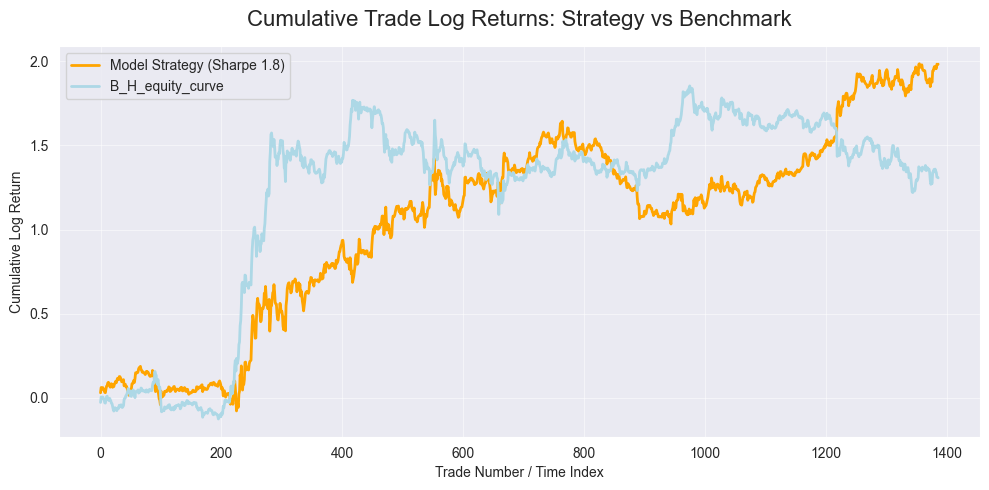

Strategy vs Benchmark Correlation (R): 0.1229
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.159
Date:                Fri, 05 Dec 2025   Prob (F-statistic):              0.142
Time:                        11:08:49   Log-Likelihood:                 3077.8
No. Observations:                1387   AIC:                            -6152.
Df Residuals:                    1385   BIC:                            -6141.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [105]:
# Visualize equity curve in log space
from visualization import plot_cum_trade_log_returns

plot_cum_trade_log_returns(results_df,"equity_curve_net",benchmark_col="B_H_equity_curve")

print(f"Strategy vs Benchmark Correlation (R): {correlation_val:.4f}")

import statsmodels.api as sm

# Analyze OLS Regression to isolate Alpha vs Beta performance
data_pd = results_df.select(['trade_log_return_net',"B_H_log_return"]).to_pandas()

Y = data_pd['trade_log_return_net']
X = data_pd['B_H_log_return']

# Add the Constant
X_with_const = sm.add_constant(X)

# Run the Regression
model = sm.OLS(y, X_with_const).fit(cov_type='HC1')

# Print the Summary
print(model.summary())

### Conclusion: Evaluating the signal

* The primary objective of this project was to determine if a linear machine learning model could extract a predictive edge from 8-hour price and volume data. The final performance metrics and econometric tests suggest that the model has successfully isolated a genuine, idiosyncratic signal.
* Initial analysis suggested a slight correlation with the benchmark. However, after re-running the regression with (HC1) Standard Errors to account for the fat tails in crypto returns, the strategy proved to be statistically market neutral. The Beta coefficient dropped to non-significance ($p=0.14$), confirming that the returns are driven by the model's logic rather than broad market exposure.
* The model generates an Alpha of 13 basis points per 8-hour period. While the statistical significance ($p=0.059$) falls just shy of the 5% threshold, a 94% confidence level for a single-factor model is a strong result. It suggests the strategy is capturing a real inefficiency rather than just random noise.
* While the signal is robust, the risk profile requires refinement. The strategy endured a 45% drawdown due to its always-on nature during high volatility regimes. Future iterations would benefit from a volatility filter to size down positions during turbulent market conditions, likely improving the risk-adjusted returns.
* The project demonstrates that a simple linear architecture, when fed with economically grounded features, can generate significant uncorrelated alpha, provided the risk is properly managed.

In [106]:
import torch
torch.save(trained_model.state_dict(), 'model_weights.pth')